# Project Milestone 2 Pipeline
* That you can handle the data in its size.
* That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
* That you considered ways to enrich, filter, transform the data according to your needs.
* That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
* That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
movie_cols = ["wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"]
movie_df = pd.read_csv(
    './rawdata/MovieSummaries/movie.metadata.tsv', 
    sep="\t", 
    names=movie_cols
)
#characters_df = pd.read_csv(
#    './MovieSummaries/character.metadata.tsv',
#    index_col=False, 
#    sep="\t", 
#    names=["wiki_id", "freebase_id", "X", "character_name", "actor_dob", "actor_gender", "actor_height", "actor_ethnicity", "actor_name", "actor_release_date_age"]
#)
#characters_df = characters_df.drop(columns="X")
name_df = pd.read_csv(
    './rawdata/MovieSummaries/name.clusters.txt', 
    sep="\t",
    names = ['character_name', "freebase_id"]
)

## Basic Data Cleaning

In [36]:
import re

# Parses the multi value structure of the dataset format into a sorted array of items
def parse_multi_values(x): 
    if not x : 
        return []
    x = x.split(',')
    result = []
    for combo in x: 
        combo = combo.split(":")
        if len(combo) > 1: 
            combo[1] = re.sub("[^a-zA-Z0-9\s]+", "", combo[1])
            combo[1] = re.sub("^\s", "", combo[1])
            result.append(combo[1])
    return sorted(result)

# Parses the date format into an int representing only the year. Values with missing entries are given NaN.
def parse_date(x):
    if not x or x == np.nan:
        return np.NaN
    return str(x).split("-")[0]

# Parse multi value attributes into arrays
for attribute in ["languages", "countries", "genres"]:
    movie_df[attribute] = movie_df[attribute].apply(parse_multi_values)

# Parse release-date to all use the year as an int (don't need increased granularity right now)
movie_df["release_date"] = movie_df["release_date"].apply(parse_date)


## Analyzing missing values

{'revenue': 73340, 'runtime': 20450}


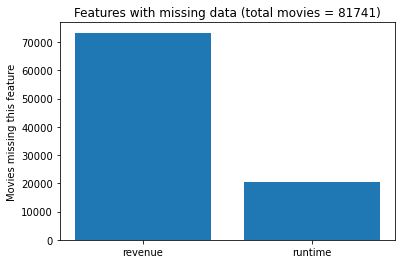

In [47]:
# Let's check to what extent we have missing data
# For each column, count the number of missing data and plot a bar graph
def analyze_missing_values(df : pd.DataFrame): 
    # Dictionary from col to missing values count 
    missing = {}
    for col in df.columns:
        num_na = df[col].isna().sum()
        if num_na > 0:
            missing[col] = num_na
    print(missing)
    plt.bar(list(missing.keys()), list(missing.values()))
    plt.title("Features with missing data (total movies = " + str(df.shape[0]) + ")")
    plt.ylabel("Movies missing this feature")
    plt.show()

# As we can see, roughly 7/8 of all movies are missing the revenue data and 2/8 runtime data
analyze_missing_values(movie_df)

## Cleaning up "release_date"

In [47]:

movie_count = movie_df.groupby("release_date").count()["wiki_id"]
movie_count = movie_count.dropna()
movie_count = movie_count.sort_values()[1:-1]
movie_count.describe()

count     129.000000
mean      580.139535
std       533.896083
min         1.000000
25%       272.000000
50%       518.000000
75%       687.000000
max      2465.000000
Name: wiki_id, dtype: float64

In [48]:
movie_df.head(10)

,wiki_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],"{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],"{""/m/09c7w0"": ""United States of America""}","[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],"{""/m/05b4w"": ""Norway""}","[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],"{""/m/07ssc"": ""United Kingdom""}","[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],"{""/m/0345h"": ""Germany""}",[Drama]
5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]","{""/m/09c7w0"": ""United States of America""}","[Short Film, Silent film, Indie, Blackandwhite..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],"{""/m/0hzlz"": ""South Africa""}","[Family Film, Fantasy, Adventure, World cinema]"
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],"{""/m/09c7w0"": ""United States of America""}","[Musical, Comedy, Blackandwhite]"
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,[Spanish Language],"{""/m/0jgd"": ""Argentina""}","[Musical, Drama, Comedy]"
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,[English Language],"{""/m/07ssc"": ""United Kingdom""}","[Horror, Supernatural]"
